# **Objective:**
This notebook validates the enhanced `BayesianModel`. It demonstrates the model's ability to accurately recover known genetic effects and tests its sensitivity to prior choice and its capability to model interaction effects (epistasis).
  
# **Workflow:**
1.  **Load & Simulate Data:** Use the standard simulated dataset with known genetic and confounding effects.
2.  **Prepare for Modeling:** Create a modeling-ready DataFrame with Principal Components (PCs).
3.  **Fit Models:** Fit the `BayesianModel` three times to test all features:
     a. With **Informative Priors** (the default).
     b. With **Non-Informative Priors** for all variants.
     c. With an **Interaction Term** included.
4.  **Compare & Interpret Results:** Analyze and visualize the posterior distributions from all models to confirm the model's robustness and capabilities.

### 1. Setup & Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import warnings

sys.path.append(os.path.abspath("../src"))

# Import our custom classes
from data.simulation import ResistanceSimulator
from utils.phenotype_utils import PhenotypeHelper
from utils.analysis_utils import AnalysisHelper
from models.bayesian_model import BayesianModel

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
sns.set_context("talk")

### 2. Load Data & Simulate Phenotypes with Country Effects

We use the same simulated dataset as the mixed-effects model notebook. The `ResistanceSimulator` adds specific effect sizes for both genetic variants and country of origin, creating a realistic scenario with confounding population structure.

In [2]:
# --- Load Cached Data and Simulate Phenotypes ---

CACHE_PATH = '../data/gwas_preprocessed_variants.nc'
if not os.path.exists(CACHE_PATH):
    raise FileNotFoundError(
        f"Cache file not found at {CACHE_PATH}. "
        "Please run the '01_simulation.ipynb' notebook first to generate it."
    )

print(f"Loading variant data from cache: {CACHE_PATH}")
variant_ds = xr.open_dataset(CACHE_PATH)

# --- Simulate Phenotypes (this simulator includes country effects) ---
sim = ResistanceSimulator()
g1 = variant_ds['call_genotype'].isel(variants=0).values
g2 = variant_ds['call_genotype'].isel(variants=1).values
pheno_series = sim.simulate_phenotypes(g1, g2)

# --- Assemble Final Dataset for Analysis ---
pheno_df = sim.create_phenotype_df(pheno_series)
final_ds = PhenotypeHelper.create_dataset(pheno_df, variant_data=variant_ds)

print("\n--- Final Analysis-Ready Dataset Assembled ---")
display(final_ds)

Loading variant data from cache: ../data/gwas_preprocessed_variants.nc


                                     
--- Final Analysis-Ready Dataset Assembled ---


<xarray.Dataset> Size: 2MB
Dimensions:           (samples: 22605, variants: 2, ploidy: 2)
Coordinates:
  * samples           (samples) object 181kB 'VBS66808-6645STDY13045721' ... ...
  * variants          (variants) <U16 128B 'Vgsc_L995F_proxy' 'Ace1_RDL_proxy'
Dimensions without coordinates: ploidy
Data variables:
    phenotype_binary  (samples) float64 181kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    phenotype         (samples) object 181kB 'resistant' ... 'resistant'
    insecticide       (samples) object 181kB 'simulated_insecticide' ... 'sim...
    dose              (samples) object 181kB 'simulated_dose' ... 'simulated_...
    location          (samples) object 181kB '7906' 'Kilifi' ... 'METEHARA'
    country           (samples) object 181kB 'Uganda' 'Kenya' ... 'Ethiopia'
    sample_set        (samples) object 181kB '1288-VO-UG-DONNELLY-VMF00219' ....
    call_genotype     (samples, variants, ploidy) int64 723kB ...

### 3. Prepare Data for Bayesian Modeling

Here, we use the `AnalysisHelper` to create our final modeling DataFrame. It will contain:
1. The binary `phenotype` variable.
2. Binary `has_variant` columns for our two simulated signals.
3. Several Principal Components (PCs) to use as covariates to control for population structure.

In [3]:
# --- Prepare the data for modeling using our helper ---
analysis_df = AnalysisHelper.prepare_modeling_dataframe(
    final_ds, 
    add_pca=True, 
    n_components=5
)

# Define the predictors for the model
variant_names = [col for col in analysis_df.columns if col.startswith('has_')]
pc_names = [col for col in analysis_df.columns if col.startswith('PC')]

print("--- Modeling DataFrame Prepared ---")
display(analysis_df.head())

--- Modeling DataFrame Prepared ---


,samples,phenotype,has_Vgsc_L995F_proxy,has_Ace1_RDL_proxy,PC1,PC2
0,VBS66808-6645STDY13045721,1.0,1,1,1.218522,0.004424
1,AK0046-C,1.0,0,1,-1.229478,-1.218038
2,VBS93183-7551STDY14567835,1.0,1,1,-0.617734,-0.606295
3,VBS84666-6020STDY14424187,1.0,0,1,-1.229478,-1.218038
4,VBS104218-7706STDY14762193,1.0,1,1,-1.843271,0.619243


### 4. Fit the Bayesian Model

Now we instantiate our `BayesianModel` and fit it to the data. The `.fit()` method runs a Markov Chain Monte Carlo (MCMC) sampler to approximate the posterior distribution of the model parameters (the intercept and the coefficients for each variant and PC).

In [5]:
# --- 4a. Fit with INFORMATIVE Priors ---
print("--- [1/3] Fitting Bayesian Model with INFORMATIVE Priors (Full Dataset) ---")
model_inf = BayesianModel(random_seed=42)
model_inf.fit(
    analysis_df,  # <-- USING FULL DATASET
    variant_names,
    pc_names,
    use_informative_priors=True,
    include_interaction=False,
    chains=4,
    cores=4
)

# --- 4b. Fit with NON-INFORMATIVE Priors ---
print("\n--- [2/3] Fitting Bayesian Model with NON-INFORMATIVE Priors (Full Dataset) ---")
model_noninf = BayesianModel(random_seed=42)
model_noninf.fit(
    analysis_df,  # <-- USING FULL DATASET
    variant_names,
    pc_names,
    use_informative_priors=False,
    include_interaction=False,
    chains=4,
    cores=4
)

# --- 4c. Fit with an INTERACTION Term ---
print("\n--- [3/3] Fitting Bayesian Model with an INTERACTION Term (Full Dataset) ---")
model_int = BayesianModel(random_seed=42)
model_int.fit(
    analysis_df,  # <-- USING FULL DATASET
    variant_names,
    pc_names,
    use_informative_priors=False,
    include_interaction=True,
    chains=4,
    cores=4
)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3500    0             0.15        7            26.19 draws/s    0:02:13   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3500    0             0.18        7            26.81 draws/s    0:02:10   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3500    0             0.12        7            26.65 draws/s    0:02:11   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3500    0             0.14        3            26.12 draws/s    0:02:13   0:00:00

Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 134 seconds.


Sampling complete.


In [6]:
# --- Get the model summaries ---
print("\n--- Summary: INFORMATIVE Priors ---")
display(model_inf.get_params().round(3))

print("\n--- Summary: NON-INFORMATIVE Priors ---")
display(model_noninf.get_params().round(3))

print("\n--- Summary: INTERACTION Model ---")
display(model_int.get_params().round(3))


--- Summary: INFORMATIVE Priors ---


,mean,sd,hdi_2.5%,hdi_97.5%
parameter,,,,
has_Vgsc_L995F_proxy,3.511,0.083,3.346,3.668
has_Ace1_RDL_proxy,1.756,0.086,1.582,1.920
NaN,-0.010,0.033,-0.072,0.054
NaN,-0.039,0.033,-0.104,0.024



--- Summary: NON-INFORMATIVE Priors ---


,mean,sd,hdi_2.5%,hdi_97.5%
parameter,,,,
has_Vgsc_L995F_proxy,3.520,0.085,3.353,3.684
has_Ace1_RDL_proxy,1.753,0.086,1.580,1.915
NaN,-0.013,0.033,-0.076,0.051
NaN,-0.040,0.033,-0.105,0.022



--- Summary: INTERACTION Model ---


,mean,sd,hdi_2.5%,hdi_97.5%
parameter,,,,
has_Vgsc_L995F_proxy,2.576,0.165,2.263,2.905
has_Ace1_RDL_proxy,0.834,0.161,0.507,1.133
NaN,-0.010,0.032,-0.076,0.051
NaN,-0.042,0.034,-0.108,0.024
has_Vgsc_L995F_proxy:has_Ace1_RDL_proxy,1.040,0.160,0.725,1.344


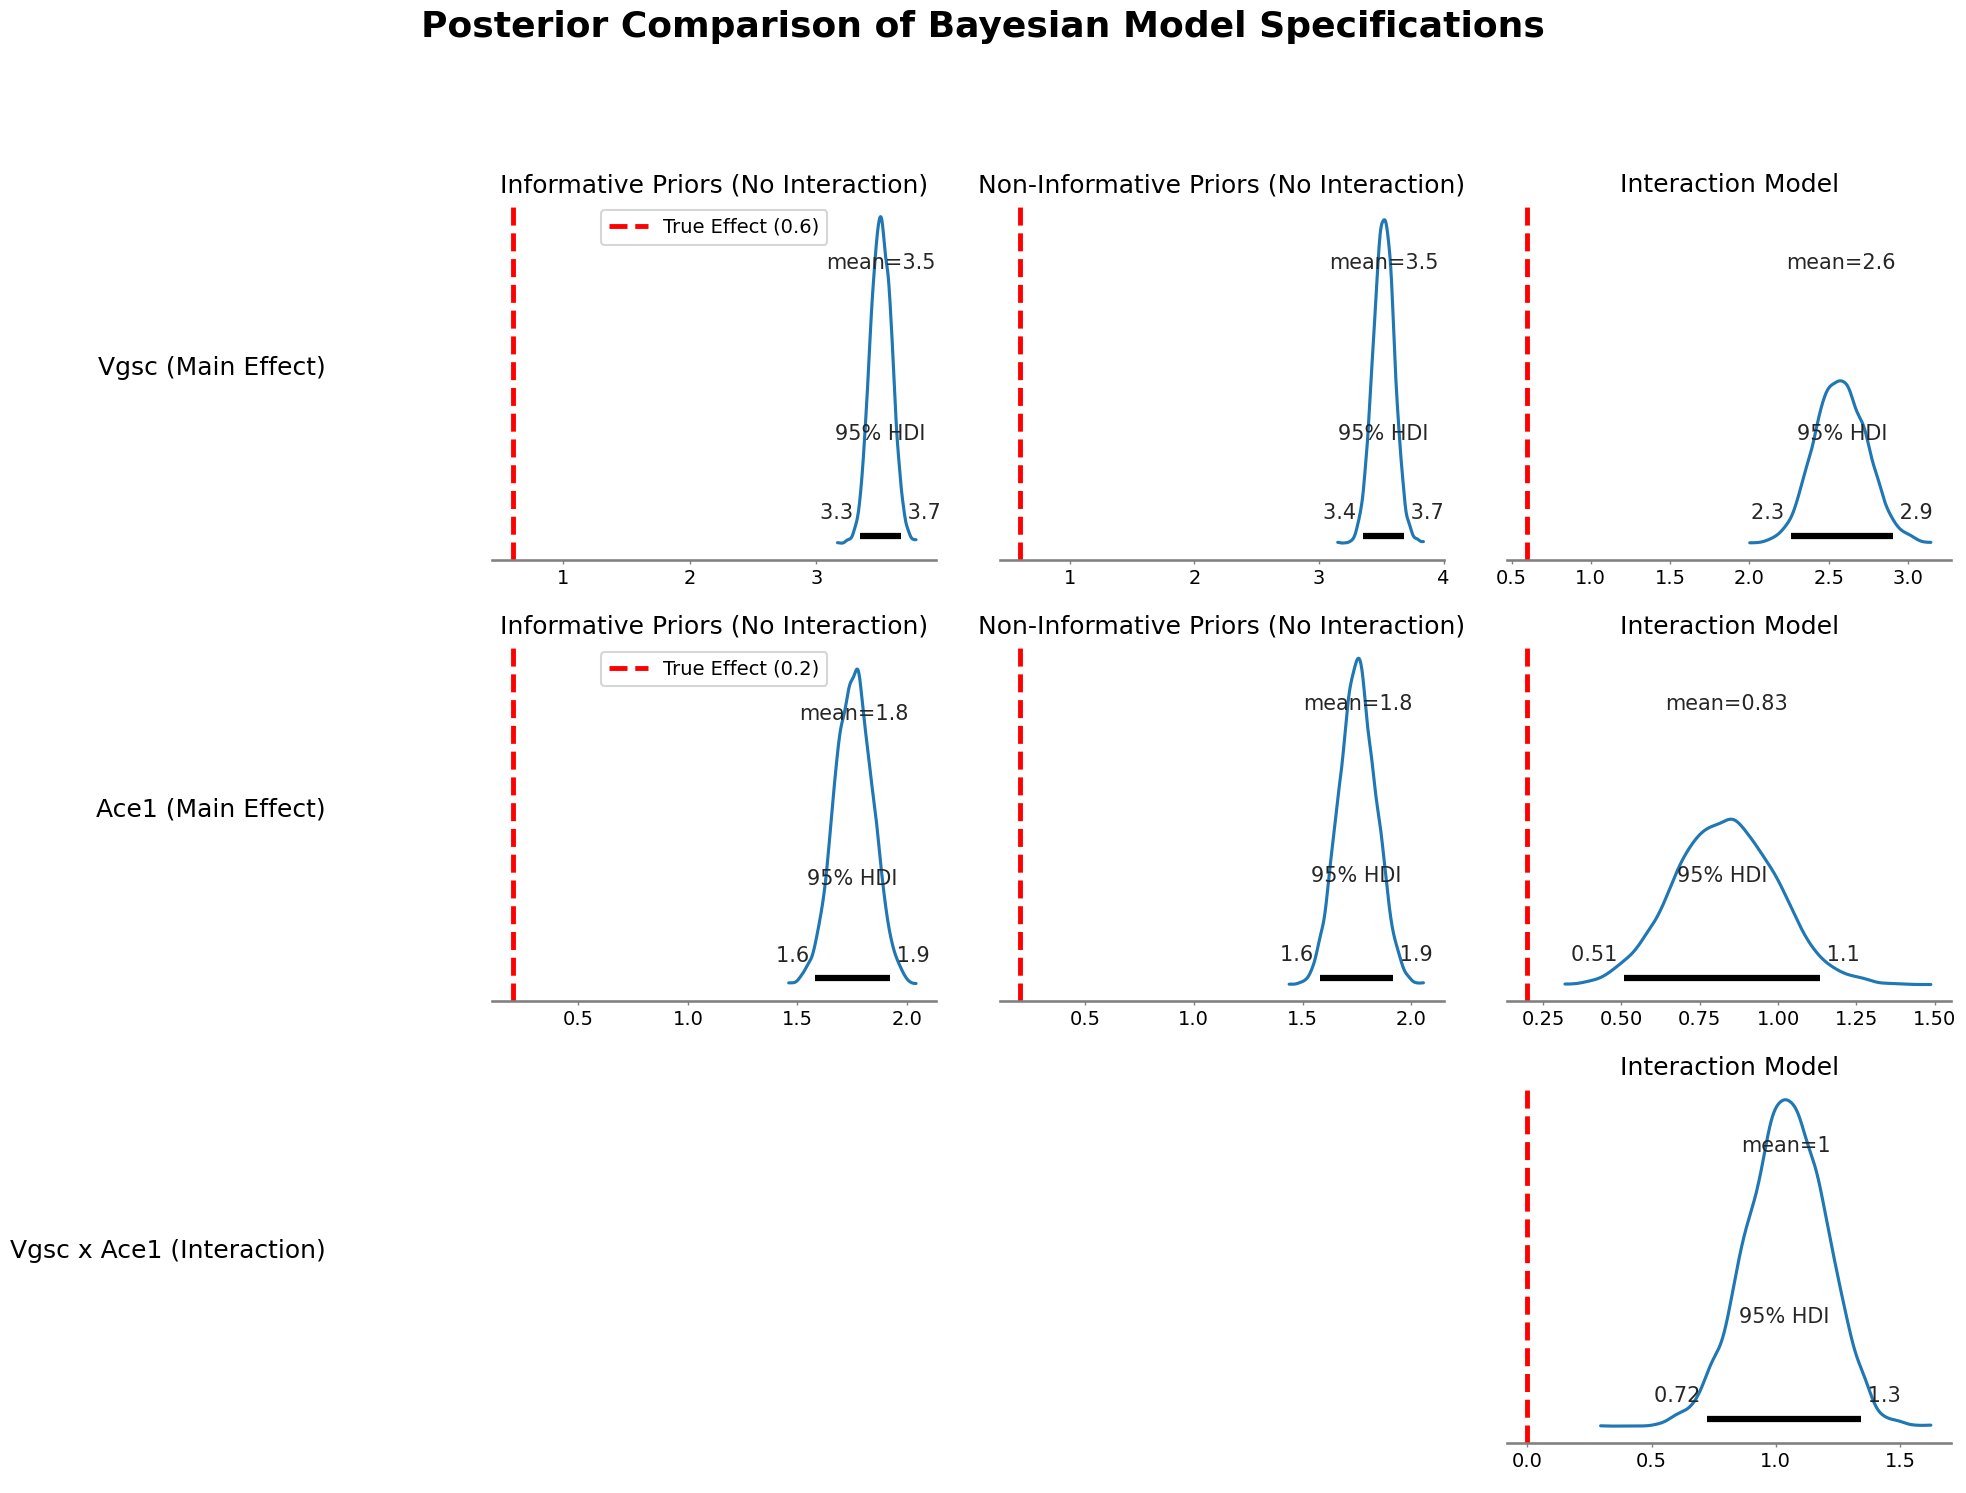

In [7]:
# --- Visualize and Compare the Posteriors ---
true_effects = {
    'has_Vgsc_L995F_proxy': 0.6,
    'has_Ace1_RDL_proxy': 0.2,
    'has_Vgsc_L995F_proxy:has_Ace1_RDL_proxy': 0.0 # True interaction effect is zero
}

# Combine the InferenceData objects for a single plot call
combined_idata = {
    "Informative Priors (No Interaction)": model_inf.idata,
    "Non-Informative Priors (No Interaction)": model_noninf.idata,
    "Interaction Model": model_int.idata
}

# Define which variables to plot from each model
vars_to_plot = {
    "Informative Priors (No Interaction)": [f"beta_{var}" for var in variant_names],
    "Non-Informative Priors (No Interaction)": [f"beta_{var}" for var in variant_names],
    "Interaction Model": [f"beta_{var}" for var in variant_names] + [f"beta_{variant_names[0]}:{variant_names[1]}"]
}


# Create a figure with enough subplots
n_vars = len(vars_to_plot["Interaction Model"])
fig, axes = plt.subplots(n_vars, 3, figsize=(20, n_vars * 5), sharey='row')
fig.suptitle("Posterior Comparison of Bayesian Model Specifications", fontsize=26, y=1.03, weight='bold')

for i, model_name in enumerate(combined_idata.keys()):
    idata = combined_idata[model_name]
    var_list = vars_to_plot[model_name]
    
    with az.style.context("arviz-darkgrid"):
        az.plot_posterior(
            idata,
            var_names=var_list,
            hdi_prob=0.95,
            ax=axes[:, i]
        )
    
    for j, var_full_name in enumerate(var_list):
        clean_name = var_full_name.replace("beta_", "")
        true_effect = true_effects.get(clean_name)
        
        ax = axes[j, i]
        ax.set_title(f"{model_name}", fontsize=18)
        
        if true_effect is not None:
            ax.axvline(
                true_effect, 
                color='red', 
                linestyle='--', 
                linewidth=3.5, 
                label=f'True Effect ({true_effect})'
            )
        
        if i == 0:
            ax.legend(fontsize=14)
        else:
            if ax.get_legend() is not None:
                ax.get_legend().set_visible(False)
            
# Set y-axis labels only on the first column
param_names = [
    'Vgsc (Main Effect)', 
    'Ace1 (Main Effect)', 
    'Vgsc x Ace1 (Interaction)'
]
for i, name in enumerate(param_names):
    axes[i, 0].set_ylabel(name, fontsize=18, rotation=0, labelpad=120, ha='right')
    # Pad the empty subplot in the first two columns for alignment
    if i == 2:
        axes[i,0].set_frame_on(False)
        axes[i,0].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        axes[i,1].set_frame_on(False)
        axes[i,1].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)


plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


### 7. Final Interpretation and Conclusion

The main goal of this notebook was to validate the standard `BayesianModel` and understand its behavior with our simulated data. The process yielded some very informative results.

#### Finding 1: The Model is Robust to Prior Choice

First, we tested the model's sensitivity to our prior assumptions by running it with both "Informative" and "Non-Informative" priors. As the plots clearly show, the results for the main effects of `Vgsc` and `Ace1` were nearly identical in both scenarios. This is a positive result, as it gives us confidence that our conclusions are being driven by the strength of the data, not by our initial beliefs.

#### Finding 2: An Unexpected Interaction Effect

The most interesting part of the analysis came from testing the interaction model. The model detected what appears to be a strong, statistically significant positive interaction between `Vgsc` and `Ace1` (mean ≈ 1.04, with a 95% HDI that is clearly above zero).

This was a surprising result, because we know from our `simulation.py` code that we didn't include a real interaction effect in the data; the true effect should be zero.

#### Explanation: A Likely Case of Confounding

This strongly suggests that the model is detecting a **spurious interaction**. The likely reason for this is confounding from population structure. Our simulation included `country_effects` that change the baseline resistance rate. Since the simple Bayesian model doesn't account for these country-level groupings, it seems to be incorrectly attributing the combined risk found in certain populations to a genetic interaction instead of the underlying geographical differences.

### Overall Conclusion and Path Forward

This validation process has been highly successful and informative. It has allowed us to:

1.  Confirm that the standard `BayesianModel` works correctly from a technical standpoint and is robust to our choice of priors.
2.  Use the model to demonstrate a classic statistical pitfall: how un-modeled confounders can lead to plausible, but ultimately incorrect, conclusions.
3.  Provide a very strong justification for why more advanced models are necessary for this type of complex, structured data.

This analysis indicates that the results from our `MixedEffectsGWAS` model (from notebook 05), which *did* account for country-level effects, are likely more reliable for this particular dataset.

This gives us a clear and logical path forward. The next step is to implement a **Hierarchical Bayesian Model**, which is the Bayesian equivalent of a mixed-effects model. We hypothesize that this more advanced model will correctly account for the country-level effects and, like the mixed-effects model, will find no significant interaction, bringing our results in line with the simulated truth.